In [1]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
# !pip install tensorflow
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
# !pip install scikit-learn
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import shutil
import pandas as pd

2024-06-14 22:08:53.054178: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Define Necesseary Functions and Variables 

In [2]:
n_components_threshold = 0.40 ## percent variance that will be explained between componet PCAs
subcategories = [
    "process diagram",
    "2x2 matrix",
    "venn diagram",
    "conceptual diagram",
    "cycle",
    "hierarchical diagram",
    "bar chart",
    "stacked bar chart",
    "line graph",
    "scatter plot",
    "mixed statistical plot (more than 1 statistical plot type)",
    "data structure",
    "data collection, data analysis, data gathering diagrams",
    "heatmap",
    "data map",
    "organizational chart",
    "timeline",
    "drawing",
    "photo"
]


def load_and_preprocess_images(yearly_data, target_size=(224, 224)):
    image_paths = ["../" + figure_path for figure_path in yearly_data["new image path"]]
    images = [load_img(path, target_size=target_size) for path in image_paths]
    images_array = np.array([img_to_array(image) for image in images])
    images_array = preprocess_input(images_array)
    return images, images_array, image_paths

def extract_features(images_array):
    model = VGG16(weights='imagenet', include_top=False)
    features = model.predict(images_array)
    features_flattened = features.reshape(features.shape[0], -1)
    return features_flattened

def reduce_dimensions(features, n_components=30):
    pca = PCA(n_components=n_components)
    reduced_features = pca.fit_transform(features)
    return reduced_features, pca

def perform_kmeans(reduced_features, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters)
    labels = kmeans.fit_predict(reduced_features)
    return labels, kmeans, reduced_features

def create_cluster_directories(base_dir, n_clusters):
    for i in range(1, n_clusters + 1):
        path = os.path.join(base_dir, f'cluster_{i}')
        if not os.path.exists(path):
            os.makedirs(path)

def save_images_to_clusters(image_paths, labels, base_dir, n_clusters):
    for path, label in zip(image_paths, labels):
        directory = os.path.join(base_dir, f'cluster_{label+1}')
        shutil.copy(path, directory)

def visualize_clusters(reduced_features, labels, cluster_centers):
    plt.figure(figsize=(10, 6))
    # Use a colormap that provides up to 18 distinct colors. 'tab20' can provide up to 20 distinct colors.
    colors = plt.cm.tab20(np.linspace(0, 1, len(cluster_centers)))
    for i in range(cluster_centers.shape[0]):
        plt.scatter(reduced_features[labels == i, 0], reduced_features[labels == i, 1], s=50, c=colors[i], label=f'Cluster {i+1}')
    # plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], s=100, c='yellow', marker='*', edgecolors='black', label='Centroids')
    plt.title('K-Means Clustering Visualization')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.show()

def visualize_clusters_with_subcategories(reduced_features, labels, cluster_centers, subcategories):
    plt.figure(figsize=(10, 6))
    
    # Generate a color map for subcategories
    unique_subcategories = np.unique(subcategories)
    colors = plt.cm.tab20(np.linspace(0, 1, len(unique_subcategories)))  # Using 'tab20' colormap for better color distinction
    color_map = {subcat: color for subcat, color in zip(unique_subcategories, colors)}
    
    # Plot each point
    for i, label in enumerate(labels):
        plt.scatter(reduced_features[i, 0], reduced_features[i, 1], color=color_map[subcategories[i]], label=subcategories[i] if subcategories[i] not in plt.gca().get_legend_handles_labels()[1] else "")
    
    # Plot centroids
    # plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], s=100, c='yellow', marker='*', edgecolors='black', label='Centroids')
    
    plt.title('Cluster Visualization by Subcategory')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(title='Subcategory', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

def delete_all_subdirectories(base_dir):
    # Check if the base directory exists
    if not os.path.exists(base_dir):
        print("The specified directory does not exist.")
        return
    
    # Loop through each item in the base directory
    for item in os.listdir(base_dir):
        # Construct the full path to the item
        item_path = os.path.join(base_dir, item)
        # Check if the item is a directory
        if os.path.isdir(item_path):
            # Remove the directory and all its contents
            shutil.rmtree(item_path)
            print(f"Deleted {item_path}")

## Load the yearly data

In [3]:
year = 2022  
file_path = f"../cropped_and_labeled_image_data/{year}_cropped_and_labeled_figs.xlsx"
yearly_figure_data = pd.read_excel(file_path)
print(f"Total figure count: {yearly_figure_data.shape[0]}")

Total figure count: 62


## Clustering for all types, except except drawing and photo


Total figure count, minus photos and drawings: 48
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step


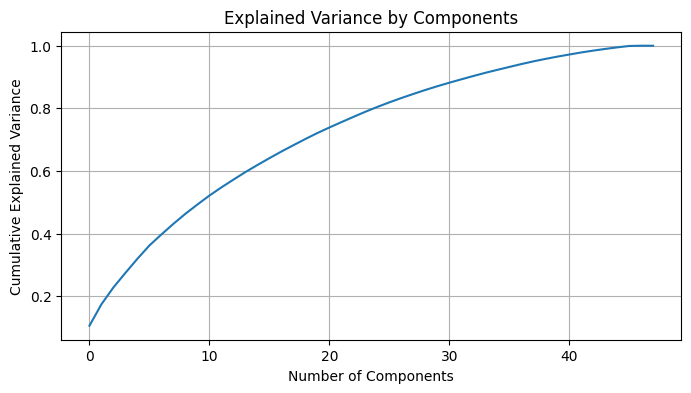

In [4]:
current_yearly_data = yearly_figure_data[~yearly_figure_data["subcategory"].isin(["photo", "drawing"])]
print(f"Total figure count, minus photos and drawings: {current_yearly_data.shape[0]}")
# Load and preprocess images
images, images_array, image_paths = load_and_preprocess_images(current_yearly_data)
subcategories = current_yearly_data['subcategory'].values

# Extract features
features_flattened = extract_features(images_array)


# Looking at explained variance - use to inform Number of Components
pca = PCA().fit(features_flattened)

# Plotting the cumulative variance
plt.figure(figsize=(8, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Components')
plt.grid(True)
plt.show()    

n_clusters: 8
n_components_40: 7
Deleted ../clustered_images/2022/no_photos_or_drawings/cluster_8
Deleted ../clustered_images/2022/no_photos_or_drawings/cluster_6
Deleted ../clustered_images/2022/no_photos_or_drawings/cluster_1
Deleted ../clustered_images/2022/no_photos_or_drawings/cluster_7
Deleted ../clustered_images/2022/no_photos_or_drawings/cluster_2
Deleted ../clustered_images/2022/no_photos_or_drawings/cluster_5
Deleted ../clustered_images/2022/no_photos_or_drawings/cluster_4
Deleted ../clustered_images/2022/no_photos_or_drawings/cluster_3


/var/folders/5b/4s4ttql508dccc90bhk9j9g80000gn/T/ipykernel_17679/3768723418.py:64: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(reduced_features[labels == i, 0], reduced_features[labels == i, 1], s=50, c=colors[i], label=f'Cluster {i+1}')


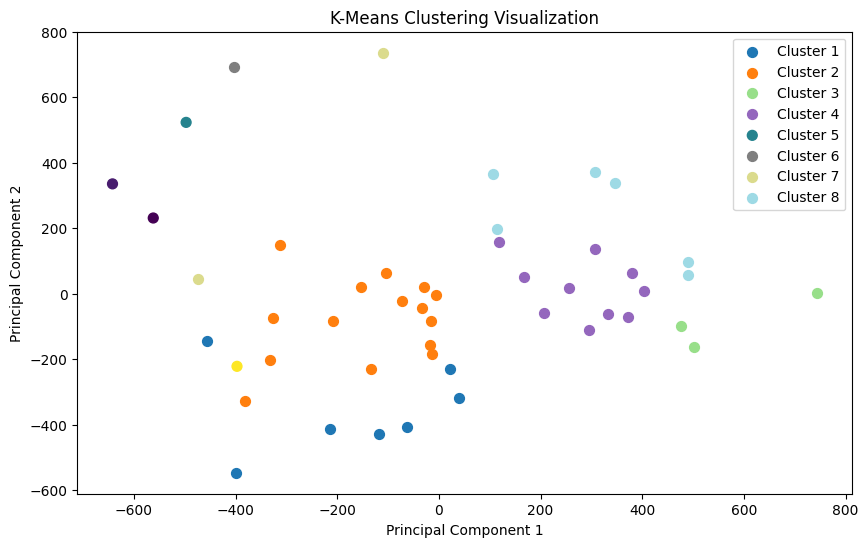

In [5]:
n_clusters = len(current_yearly_data['subcategory'].unique())  # Set the number of clusters here

n_components_above_threshold = np.where(np.cumsum(pca.explained_variance_ratio_) >= n_components_threshold)[0][0]

print(f"n_clusters: {n_clusters}")
print(f"n_components_40: {n_components_above_threshold}")

# Reduce dimensions
reduced_features, pca = reduce_dimensions(features_flattened, n_components=n_components_above_threshold )

# Perform KMeans clustering
labels, kmeans, reduced_features = perform_kmeans(reduced_features, n_clusters)

# Create directories for clusters
base_dir = '../clustered_images/2022/no_photos_or_drawings'
delete_all_subdirectories(base_dir)


create_cluster_directories(base_dir, n_clusters)

# Save images to their respective cluster directories
save_images_to_clusters(image_paths, labels, base_dir, n_clusters)

# Visualize K-Means Clusters
visualize_clusters(reduced_features, labels, kmeans.cluster_centers_)

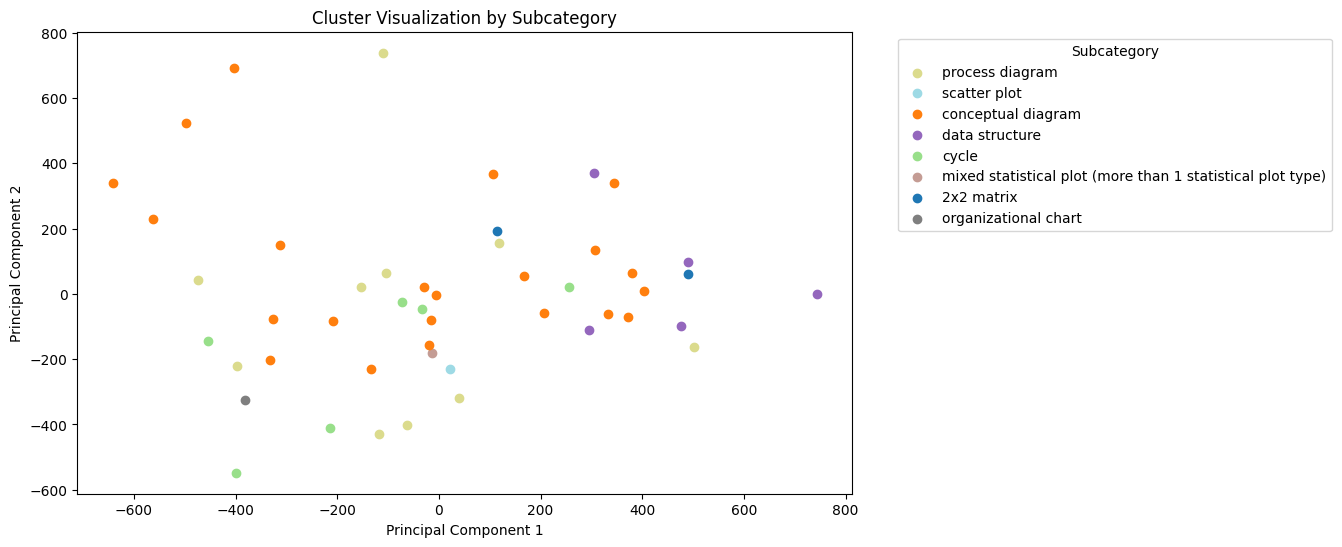

In [6]:
# Continue from PCA and clustering
reduced_features, pca = reduce_dimensions(features_flattened, n_components=n_components_above_threshold)  # Or use PCA().fit_transform directly if preferred
labels, kmeans, _ = perform_kmeans(reduced_features, n_clusters=n_clusters)

# Now plot with subcategory coloring
visualize_clusters_with_subcategories(reduced_features, labels, kmeans.cluster_centers_, subcategories)

In [7]:
# Create a DataFrame from labels and subcategories
cluster_data = pd.DataFrame({
    'Cluster': labels,
    'Subcategory': subcategories
})
# Create a pivot table to count subcategories in each cluster
subcategory_counts = pd.pivot_table(cluster_data, index='Cluster', columns='Subcategory', aggfunc='size', fill_value=0)
subcategory_counts

Subcategory,2x2 matrix,conceptual diagram,cycle,data structure,mixed statistical plot (more than 1 statistical plot type),organizational chart,process diagram,scatter plot
Cluster,,,,,,,,
0,1,6,0,0,0,0,2,0
1,1,6,1,4,0,0,1,0
2,0,0,0,0,0,0,1,0
3,0,3,0,0,0,0,1,0
4,0,0,3,0,0,0,2,1
5,0,1,0,0,0,0,0,0
6,0,6,2,0,1,1,3,0
7,0,0,0,1,0,0,0,0


## Clustering for those of type "diagram" 

In [8]:
clustering_types = [
   "process diagram",
    "conceptual diagram",
    "cycle",
    "hierarchical diagram",
    "data structure",
    "data collection, data analysis, data gathering diagrams"
]
current_yearly_data = yearly_figure_data[yearly_figure_data["subcategory"].isin(clustering_types)]
print(f"Figure count in selected subcategories: {current_yearly_data.shape[0]}")

Figure count in selected subcategories: 43


2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step


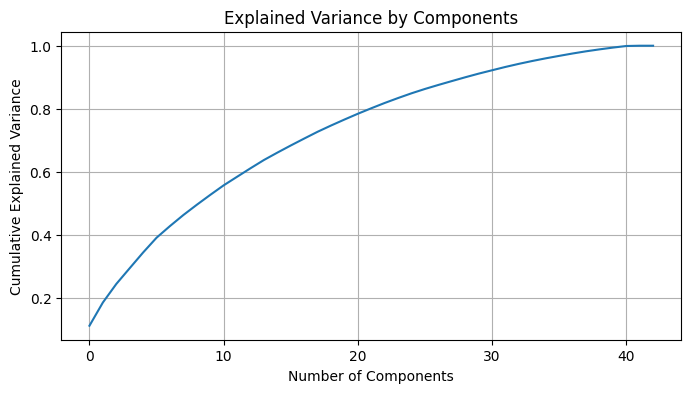

In [9]:
# Load and preprocess images
images, images_array, image_paths = load_and_preprocess_images(current_yearly_data)
subcategories = current_yearly_data['subcategory'].values

# Extract features
features_flattened = extract_features(images_array)


# Looking at explained variance - use to inform Number of Components
pca = PCA().fit(features_flattened)

# Plotting the cumulative variance
plt.figure(figsize=(8, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Components')
plt.grid(True)
plt.show()    

n_clusters: 4
n_components: 6
Deleted ../clustered_images/2022/diagram_type/cluster_1
Deleted ../clustered_images/2022/diagram_type/cluster_2
Deleted ../clustered_images/2022/diagram_type/cluster_4
Deleted ../clustered_images/2022/diagram_type/cluster_3


/var/folders/5b/4s4ttql508dccc90bhk9j9g80000gn/T/ipykernel_17679/3768723418.py:64: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(reduced_features[labels == i, 0], reduced_features[labels == i, 1], s=50, c=colors[i], label=f'Cluster {i+1}')


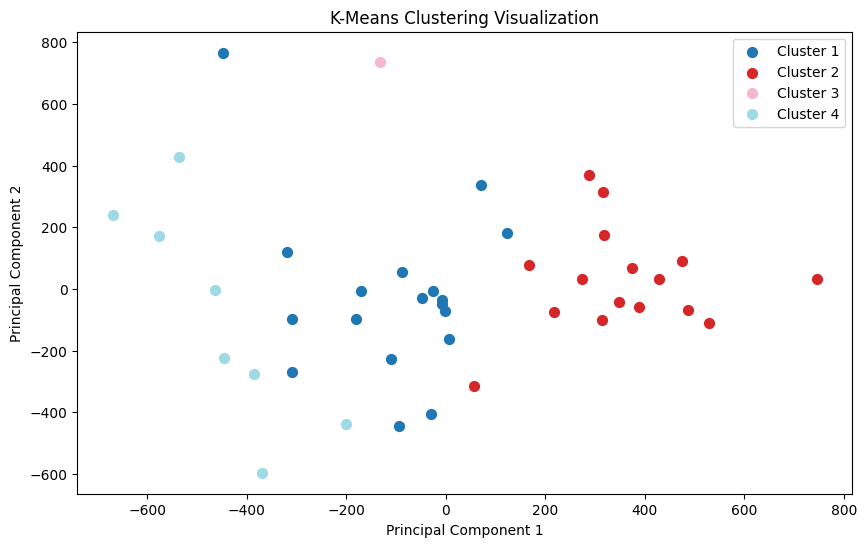

In [10]:
n_clusters = len(current_yearly_data['subcategory'].unique())  # Set the number of clusters here

n_components_above_threshold = np.where(np.cumsum(pca.explained_variance_ratio_) >= n_components_threshold)[0][0]

print(f"n_clusters: {n_clusters}")
print(f"n_components: {n_components_above_threshold}")

# Reduce dimensions
reduced_features, pca = reduce_dimensions(features_flattened, n_components=n_components_above_threshold )

# Perform KMeans clustering
labels, kmeans, reduced_features = perform_kmeans(reduced_features, n_clusters)

# Create directories for clusters
base_dir = '../clustered_images/2022/diagram_type'
delete_all_subdirectories(base_dir)


create_cluster_directories(base_dir, n_clusters)

# Save images to their respective cluster directories
save_images_to_clusters(image_paths, labels, base_dir, n_clusters)

# Visualize K-Means Clusters
visualize_clusters(reduced_features, labels, kmeans.cluster_centers_)

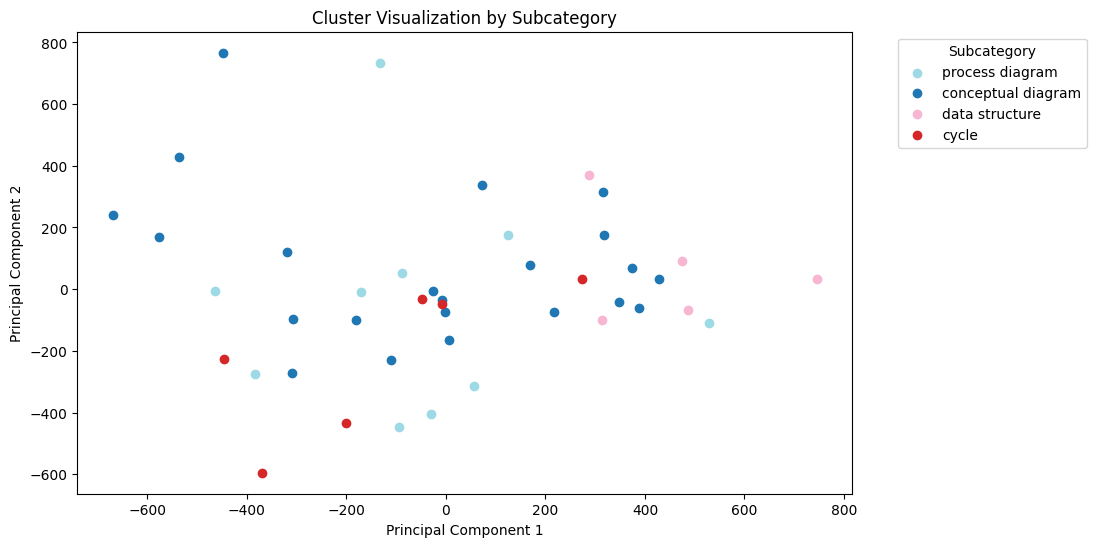

In [11]:
# Continue from PCA and clustering
reduced_features, pca = reduce_dimensions(features_flattened, n_components=n_components_above_threshold)  # Or use PCA().fit_transform directly if preferred
labels, kmeans, _ = perform_kmeans(reduced_features, n_clusters=n_clusters)

# Now plot with subcategory coloring
visualize_clusters_with_subcategories(reduced_features, labels, kmeans.cluster_centers_, subcategories)

In [12]:
# Create a DataFrame from labels and subcategories
cluster_data = pd.DataFrame({
    'Cluster': labels,
    'Subcategory': subcategories
})
# Create a pivot table to count subcategories in each cluster
subcategory_counts = pd.pivot_table(cluster_data, index='Cluster', columns='Subcategory', aggfunc='size', fill_value=0)
subcategory_counts

Subcategory,conceptual diagram,cycle,data structure,process diagram
Cluster,,,,
0,9,5,0,7
1,1,0,0,0
2,9,1,5,2
3,3,0,0,1


## Clustering for only conceptual and process diagrams only

In [13]:
clustering_types = [
   "process diagram",
    "conceptual diagram",
]
current_yearly_data = yearly_figure_data[yearly_figure_data["subcategory"].isin(clustering_types)]
print(f"Figure count in selected subcategories: {current_yearly_data.shape[0]}")

Figure count in selected subcategories: 32


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


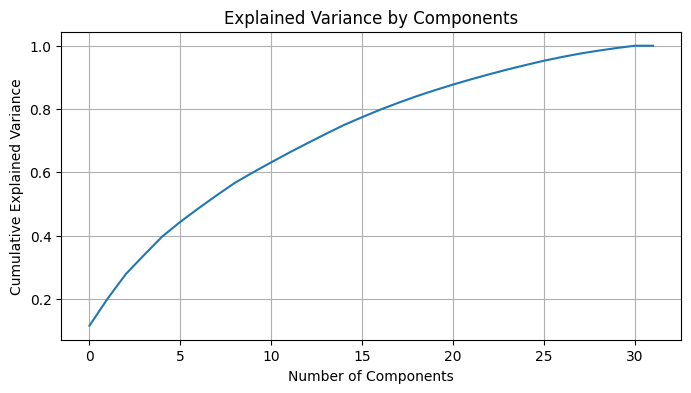

In [14]:
# Load and preprocess images
images, images_array, image_paths = load_and_preprocess_images(current_yearly_data)
subcategories = current_yearly_data['subcategory'].values

# Extract features
features_flattened = extract_features(images_array)


# Looking at explained variance - use to inform Number of Components
pca = PCA().fit(features_flattened)

# Plotting the cumulative variance
plt.figure(figsize=(8, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Components')
plt.grid(True)
plt.show()    

n_clusters: 4
n_components: 5
Deleted ../clustered_images/2022/process_and_conceptual/cluster_1
Deleted ../clustered_images/2022/process_and_conceptual/cluster_2
Deleted ../clustered_images/2022/process_and_conceptual/cluster_3


/var/folders/5b/4s4ttql508dccc90bhk9j9g80000gn/T/ipykernel_17679/3768723418.py:64: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(reduced_features[labels == i, 0], reduced_features[labels == i, 1], s=50, c=colors[i], label=f'Cluster {i+1}')


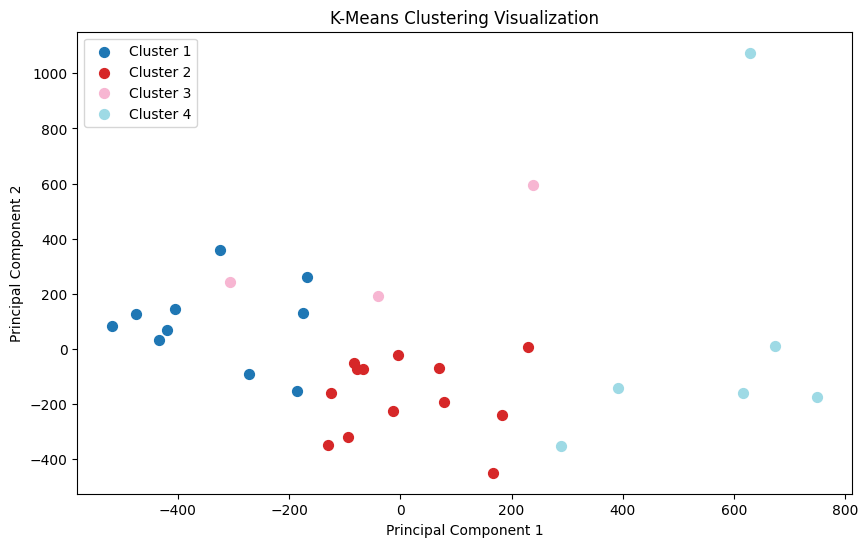

In [15]:
n_clusters = 4  # Set the number of clusters here

n_components_above_threshold = np.where(np.cumsum(pca.explained_variance_ratio_) >= n_components_threshold)[0][0]

print(f"n_clusters: {n_clusters}")
print(f"n_components: {n_components_above_threshold}")

# Reduce dimensions
reduced_features, pca = reduce_dimensions(features_flattened, n_components=n_components_above_threshold )

# Perform KMeans clustering
labels, kmeans, reduced_features = perform_kmeans(reduced_features, n_clusters)

# Create directories for clusters
base_dir = '../clustered_images/2022/process_and_conceptual'
delete_all_subdirectories(base_dir)


create_cluster_directories(base_dir, n_clusters)

# Save images to their respective cluster directories
save_images_to_clusters(image_paths, labels, base_dir, n_clusters)

# Visualize K-Means Clusters
visualize_clusters(reduced_features, labels, kmeans.cluster_centers_)

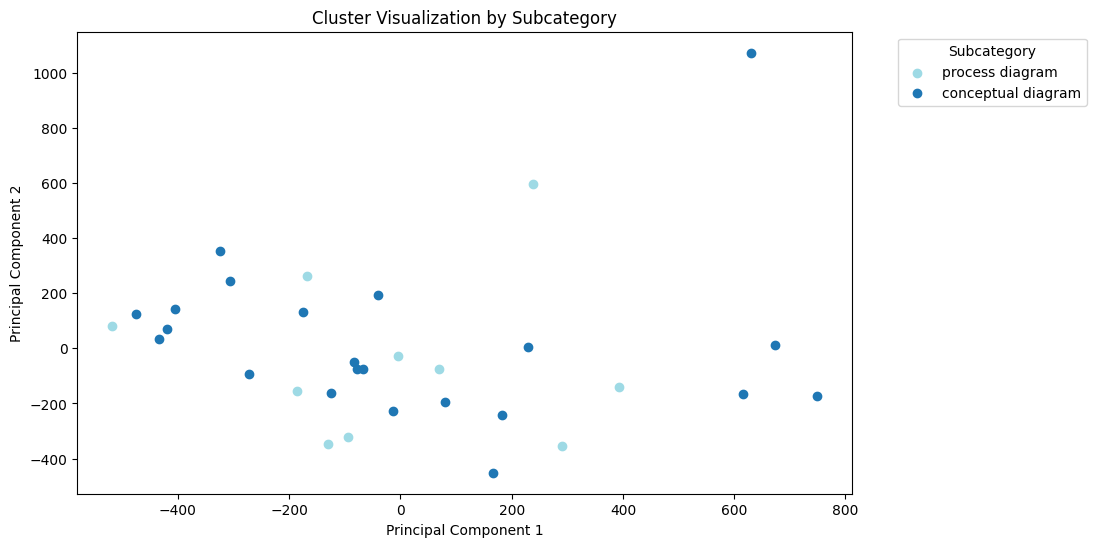

In [16]:
# Continue from PCA and clustering
reduced_features, pca = reduce_dimensions(features_flattened, n_components=n_components_above_threshold)  # Or use PCA().fit_transform directly if preferred
labels, kmeans, _ = perform_kmeans(reduced_features, n_clusters=n_clusters)

# Now plot with subcategory coloring
visualize_clusters_with_subcategories(reduced_features, labels, kmeans.cluster_centers_, subcategories)

## Clustering for each subtype 

Figure count in selected subcategories: 10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


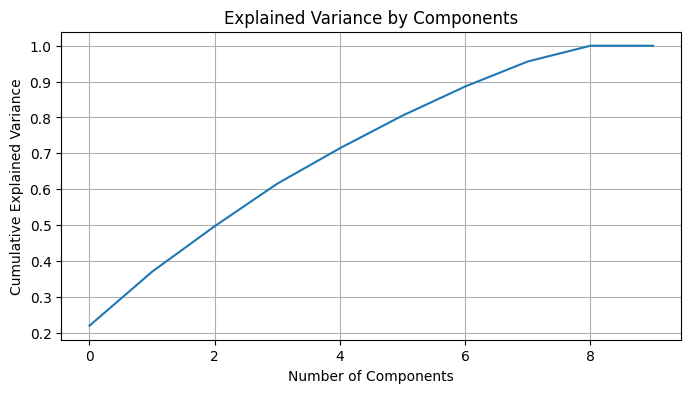

n_clusters: 3
n_components_40: 2
The specified directory does not exist.


/var/folders/5b/4s4ttql508dccc90bhk9j9g80000gn/T/ipykernel_17679/3768723418.py:64: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(reduced_features[labels == i, 0], reduced_features[labels == i, 1], s=50, c=colors[i], label=f'Cluster {i+1}')


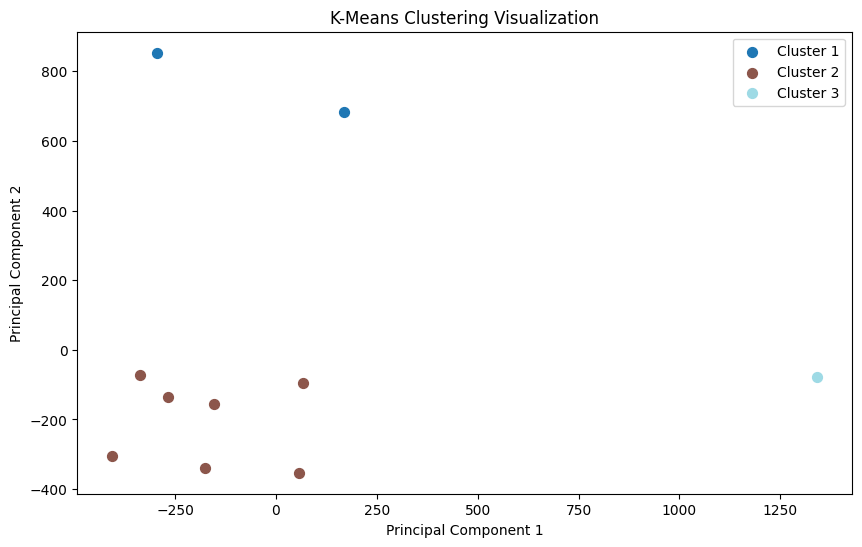

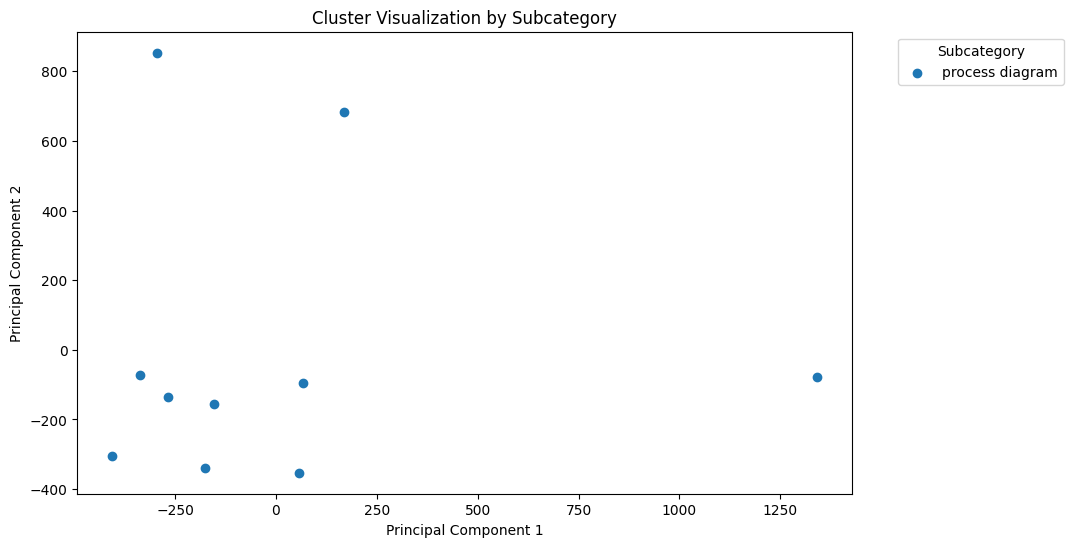

Figure count in selected subcategories: 22
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


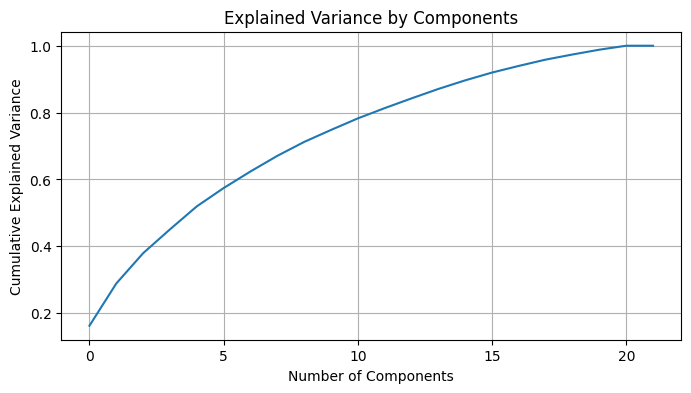

n_clusters: 3
n_components_40: 3
The specified directory does not exist.


/var/folders/5b/4s4ttql508dccc90bhk9j9g80000gn/T/ipykernel_17679/3768723418.py:64: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(reduced_features[labels == i, 0], reduced_features[labels == i, 1], s=50, c=colors[i], label=f'Cluster {i+1}')


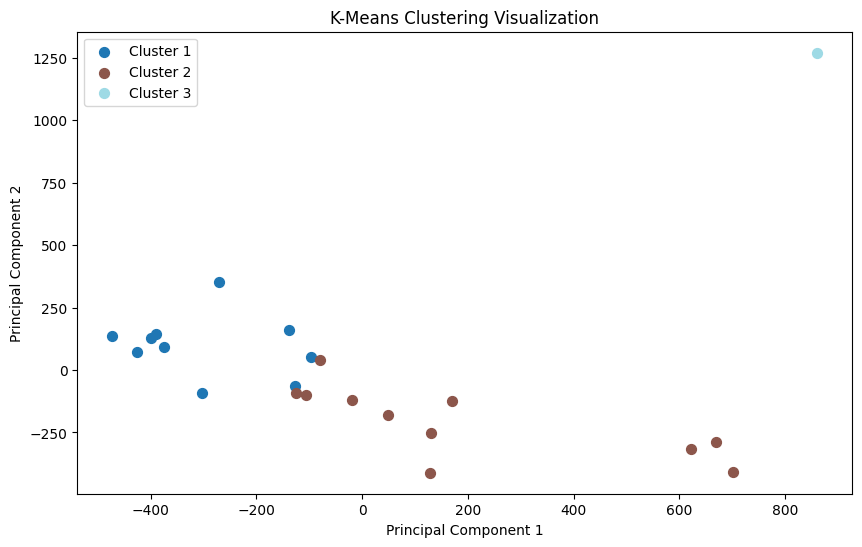

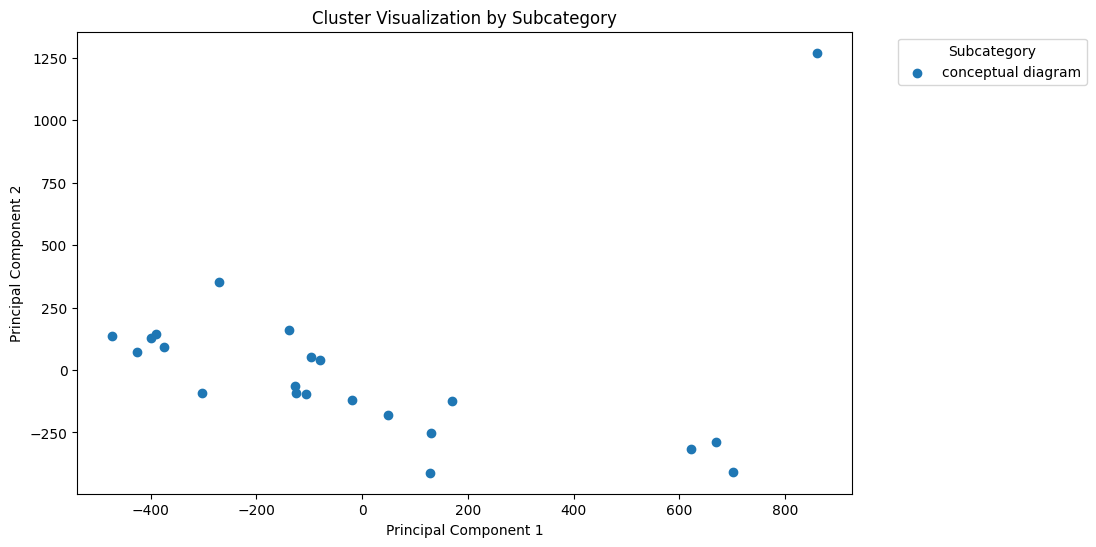

Figure count in selected subcategories: 6
Figure count in selected subcategories: 0
Figure count in selected subcategories: 5
Figure count in selected subcategories: 0


In [19]:
subcategories = [
   "process diagram",
    "conceptual diagram",
    "cycle",
    "hierarchical diagram",
    "data structure",
    "data collection, data analysis, data gathering diagrams"
]

for subcategory in subcategories:
    current_yearly_data = yearly_figure_data[yearly_figure_data["subcategory"] == subcategory]
    print(f"Figure count in selected subcategories: {current_yearly_data.shape[0]}")
    if(current_yearly_data.shape[0] > 6):
        # Load and preprocess images
        images, images_array, image_paths = load_and_preprocess_images(current_yearly_data)
        subcategories = current_yearly_data['subcategory'].values

        # Extract features
        features_flattened = extract_features(images_array)


        # Looking at explained variance - use to inform Number of Components
        pca = PCA().fit(features_flattened)

        # Plotting the cumulative variance
        plt.figure(figsize=(8, 4))
        plt.plot(np.cumsum(pca.explained_variance_ratio_))
        plt.xlabel('Number of Components')
        plt.ylabel('Cumulative Explained Variance')
        plt.title('Explained Variance by Components')
        plt.grid(True)
        plt.show()    


        n_clusters = 3  # Set the number of clusters here

        if(current_yearly_data.shape[0] < 8): 
            n_clusters  = 2

        n_components_above_threshold = np.where(np.cumsum(pca.explained_variance_ratio_) >= n_components_threshold)[0][0]

        print(f"n_clusters: {n_clusters}")
        print(f"n_components_40: {n_components_above_threshold}")

        # Reduce dimensions
        reduced_features, pca = reduce_dimensions(features_flattened, n_components=n_components_above_threshold )

        # Perform KMeans clustering
        labels, kmeans, reduced_features = perform_kmeans(reduced_features, n_clusters)

        # Create directories for clusters
        base_dir = f'../clustered_images/2022/{subcategory}'
        delete_all_subdirectories(base_dir)


        create_cluster_directories(base_dir, n_clusters)

        # Save images to their respective cluster directories
        save_images_to_clusters(image_paths, labels, base_dir, n_clusters)

        # Visualize K-Means Clusters
        visualize_clusters(reduced_features, labels, kmeans.cluster_centers_)


        # Continue from PCA and clustering
        reduced_features, pca = reduce_dimensions(features_flattened, n_components=n_components_above_threshold)  # Or use PCA().fit_transform directly if preferred
        labels, kmeans, _ = perform_kmeans(reduced_features, n_clusters=n_clusters)

        # Now plot with subcategory coloring
        visualize_clusters_with_subcategories(reduced_features, labels, kmeans.cluster_centers_, subcategories)
                